### Imports

In [1]:
import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory   
import numpy as np

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Char set 

In [2]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

comb1 = number + alphabet
comb2 = number + alphabet + ALPHABET

simple = number + ['a','b','c','g']
print(comb1)   ########################################

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Parameters

In [3]:
# number+ lower: lr = 0.003  train for 6000   size: 10000/500
# number + lower + upper: lr = 0.001  train for 6000+  size: 10000/500


CAHR_SET_LEN = len(comb1) #################################################################################################
IMAGE_HEIGHT, IMAGE_WIDTH = 60, 100
BATCH_SIZE = 25
TFRECORD_FILE = 'captcha/train.tfrecords'

x = tf.placeholder(tf.float32,[None,224,224])
y0 = tf.placeholder(tf.float32,[None])
y1 = tf.placeholder(tf.float32,[None])
y2 = tf.placeholder(tf.float32,[None])
y3 = tf.placeholder(tf.float32,[None])

lr = tf.Variable(0.002, dtype = tf.float32)

### Auxiliary function

In [4]:
def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    
    # get filenames(labels)
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = {
                                      'image': tf.FixedLenFeature([],tf.string),
                                      'label0': tf.FixedLenFeature([],tf.int64),
                                      'label1': tf.FixedLenFeature([],tf.int64),
                                      'label2': tf.FixedLenFeature([],tf.int64),
                                      'label3': tf.FixedLenFeature([],tf.int64) 
                                 })
    
    
    image = tf.decode_raw(features['image'],tf.uint8)   
      
    image = tf.reshape(image,[224,224])    
    image = tf.cast(image,tf.float32) / 255.0
    image = tf.subtract(image,0.5)
    image = tf.multiply(image,2.0)
    
    label0 = tf.cast(features['label0'],tf.int32)
    label1 = tf.cast(features['label1'],tf.int32)
    label2 = tf.cast(features['label2'],tf.int32)
    label3 = tf.cast(features['label3'],tf.int32)

    return image, label0, label1, label2, label3

### Train

In [5]:
image, label0, label1, label2, label3 = read_and_decode(TFRECORD_FILE)

# divide batches(shuffle)
image_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
        [image, label0, label1,label2,label3], batch_size = BATCH_SIZE,
        capacity = 50000, min_after_dequeue = 10000, num_threads = 1)

train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes = CAHR_SET_LEN,
    weight_decay = 0.0005,
    is_training = True)

with tf.Session() as sess:    

    #inputs: a tensor of size[batch_size, height, width,channels]
    
    X = tf.reshape(x,[BATCH_SIZE, 224, 224, 1])
    
    # forward pass 
    logits0, logits1, logits2, logits3, end_points = train_network_fn(X)

    # one-hot encoder
    one_hot_labels0 = tf.one_hot(indices = tf.cast(y0,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels1 = tf.one_hot(indices = tf.cast(y1,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels2 = tf.one_hot(indices = tf.cast(y2,tf.int32), depth = CAHR_SET_LEN)
    one_hot_labels3 = tf.one_hot(indices = tf.cast(y3,tf.int32), depth = CAHR_SET_LEN)

    # compute loss
    loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits0, labels = one_hot_labels0))
    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits1, labels = one_hot_labels1))
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits2, labels = one_hot_labels2))
    loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits3, labels = one_hot_labels3))    
    total_loss = (loss0 + loss1 + loss2 + loss3) / 4.0

    # define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(total_loss)

    # accuracy
    correct_prediction0 = tf.equal(tf.argmax(one_hot_labels0, 1), tf.argmax(logits0, 1))
    accuracy0 = tf.reduce_mean(tf.cast(correct_prediction0, tf.float32))

    correct_prediction1 = tf.equal(tf.argmax(one_hot_labels1, 1), tf.argmax(logits1, 1))
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))

    correct_prediction2 = tf.equal(tf.argmax(one_hot_labels2, 1), tf.argmax(logits2, 1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32))

    correct_prediction3 = tf.equal(tf.argmax(one_hot_labels3, 1), tf.argmax(logits3, 1))
    accuracy3 = tf.reduce_mean(tf.cast(correct_prediction3, tf.float32))

    losses = []
    accs0, accs1,accs2,accs3 = [],[],[],[]
    # init training 
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())    
    coord = tf.train.Coordinator()     # create coordinator for threads management   
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)

    for i in range(20001):        
        b_image, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch, label_batch0, label_batch1, label_batch2, label_batch3])        
        
        sess.run(optimizer, feed_dict = {x:b_image, y0: b_label0, y1:b_label1, y2:b_label2, y3:b_label3})
        
        if i % 20 == 0:
            
            if i % 5000 == 0:
                sess.run(tf.assign(lr, lr/3))
                
            acc0, acc1, acc2, acc3, loss_ = sess.run([accuracy0,accuracy1,accuracy2,accuracy3, total_loss], feed_dict = {x:b_image, y0: b_label0, y1:b_label1, y2:b_label2, y3:b_label3})
            learning_rate = sess.run(lr)
            print("Iter: %d Loss:%.3f  Accuracy:%.2f, %.2f, %.2f, %.2f Learning Rate: %.4f" % (i, loss_, acc0, acc1,acc2,acc3, learning_rate))
            
            if loss_ < 0.13:
                break
            
            # sample
            losses.append(loss_)
            accs0.append(acc0)
            accs1.append(acc1)
            accs2.append(acc2)
            accs3.append(acc3)
            
#             if i == 20000:
#                 saver.save(sess,'./captcha/models/crack_captcha.model', global_step = i)
#                 break 

    saver.save(sess,'./captcha/models/crack_captcha.model', global_step = i)            
    coord.request_stop()    
    coord.join(threads)

Iter: 0 Loss:169.616  Accuracy:0.12, 0.12, 0.16, 0.12 Learning Rate: 0.0007
Iter: 20 Loss:3.593  Accuracy:0.00, 0.00, 0.00, 0.00 Learning Rate: 0.0007
Iter: 40 Loss:3.588  Accuracy:0.04, 0.00, 0.04, 0.08 Learning Rate: 0.0007
Iter: 60 Loss:3.565  Accuracy:0.00, 0.04, 0.04, 0.04 Learning Rate: 0.0007
Iter: 80 Loss:3.569  Accuracy:0.12, 0.04, 0.08, 0.00 Learning Rate: 0.0007
Iter: 100 Loss:3.585  Accuracy:0.04, 0.00, 0.00, 0.00 Learning Rate: 0.0007
Iter: 120 Loss:3.584  Accuracy:0.00, 0.00, 0.04, 0.00 Learning Rate: 0.0007
Iter: 140 Loss:3.584  Accuracy:0.00, 0.08, 0.00, 0.00 Learning Rate: 0.0007
Iter: 160 Loss:3.585  Accuracy:0.04, 0.00, 0.04, 0.00 Learning Rate: 0.0007
Iter: 180 Loss:3.584  Accuracy:0.00, 0.12, 0.00, 0.12 Learning Rate: 0.0007
Iter: 200 Loss:3.570  Accuracy:0.12, 0.04, 0.04, 0.08 Learning Rate: 0.0007
Iter: 220 Loss:3.577  Accuracy:0.04, 0.08, 0.12, 0.00 Learning Rate: 0.0007
Iter: 240 Loss:3.581  Accuracy:0.00, 0.00, 0.04, 0.08 Learning Rate: 0.0007
Iter: 260 Loss:3

Iter: 2160 Loss:3.231  Accuracy:0.36, 0.00, 0.00, 0.04 Learning Rate: 0.0007
Iter: 2180 Loss:3.164  Accuracy:0.48, 0.04, 0.08, 0.04 Learning Rate: 0.0007
Iter: 2200 Loss:3.171  Accuracy:0.32, 0.08, 0.00, 0.00 Learning Rate: 0.0007
Iter: 2220 Loss:3.213  Accuracy:0.44, 0.04, 0.04, 0.00 Learning Rate: 0.0007
Iter: 2240 Loss:3.158  Accuracy:0.40, 0.00, 0.12, 0.00 Learning Rate: 0.0007
Iter: 2260 Loss:3.107  Accuracy:0.48, 0.08, 0.04, 0.12 Learning Rate: 0.0007
Iter: 2280 Loss:3.145  Accuracy:0.40, 0.12, 0.04, 0.00 Learning Rate: 0.0007
Iter: 2300 Loss:3.122  Accuracy:0.60, 0.00, 0.04, 0.04 Learning Rate: 0.0007
Iter: 2320 Loss:3.144  Accuracy:0.48, 0.00, 0.00, 0.00 Learning Rate: 0.0007
Iter: 2340 Loss:3.040  Accuracy:0.72, 0.00, 0.00, 0.00 Learning Rate: 0.0007
Iter: 2360 Loss:2.970  Accuracy:0.48, 0.08, 0.04, 0.08 Learning Rate: 0.0007
Iter: 2380 Loss:2.941  Accuracy:0.64, 0.04, 0.04, 0.08 Learning Rate: 0.0007
Iter: 2400 Loss:3.017  Accuracy:0.72, 0.08, 0.08, 0.08 Learning Rate: 0.0007

Iter: 4300 Loss:0.657  Accuracy:0.84, 0.76, 0.56, 0.80 Learning Rate: 0.0007
Iter: 4320 Loss:0.829  Accuracy:0.84, 0.64, 0.64, 0.84 Learning Rate: 0.0007
Iter: 4340 Loss:0.508  Accuracy:0.92, 0.80, 0.72, 1.00 Learning Rate: 0.0007
Iter: 4360 Loss:0.657  Accuracy:0.96, 0.84, 0.68, 0.64 Learning Rate: 0.0007
Iter: 4380 Loss:0.735  Accuracy:0.76, 0.76, 0.72, 0.72 Learning Rate: 0.0007
Iter: 4400 Loss:0.860  Accuracy:0.84, 0.76, 0.64, 0.68 Learning Rate: 0.0007
Iter: 4420 Loss:0.781  Accuracy:0.96, 0.64, 0.60, 0.72 Learning Rate: 0.0007
Iter: 4440 Loss:0.826  Accuracy:0.92, 0.76, 0.64, 0.68 Learning Rate: 0.0007
Iter: 4460 Loss:0.536  Accuracy:0.84, 0.84, 0.68, 0.84 Learning Rate: 0.0007
Iter: 4480 Loss:0.630  Accuracy:0.80, 0.72, 0.60, 0.92 Learning Rate: 0.0007
Iter: 4500 Loss:0.758  Accuracy:1.00, 0.64, 0.64, 0.68 Learning Rate: 0.0007
Iter: 4520 Loss:0.731  Accuracy:0.92, 0.68, 0.60, 0.76 Learning Rate: 0.0007
Iter: 4540 Loss:0.607  Accuracy:1.00, 0.72, 0.72, 0.64 Learning Rate: 0.0007

In [6]:
import matplotlib.pyplot as plt

def plot_accuracy(): 
    fig,ax = plt.subplots()     
    plt.xlabel('Training epochs')  
    plt.ylabel('Accuracy') 
    x = range(len(accs0))
    #ax.set_ylim([0,0.8])  
    #ax.set_xlim([58,42])
    ax.plot(x,accs0,'g',label = 'digit-1')    
    ax.plot(x,accs1,'y',label = 'digit-2')
    ax.plot(x,accs2,'r',label = 'digit-3')
    ax.plot(x,accs3,'b',label = 'digit-4')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 0), loc = 4, borderaxespad=0.)  
    plt.show()  
    
    
def plot_loss():
    fig,ax = plt.subplots()     
    plt.xlabel('Training epochs')  
    plt.ylabel('Loss values') 
    x = range(len(losses[1:]))
    #ax.set_ylim([0,1])  
    #ax.set_xlim([58,42])
    ax.plot(x,losses[1:],'g',label = 'train set')    
    #ax.plot(x,loss_test,'r',label = 'test set') 
    #ax.plot(x,loss_val,'y',label = 'validation set')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 1, borderaxespad=0.)  
    plt.show() 

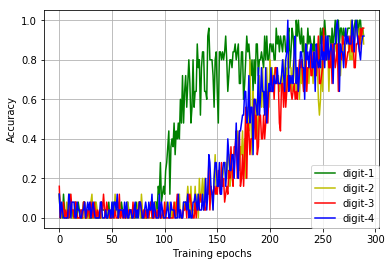

In [7]:
plot_accuracy()

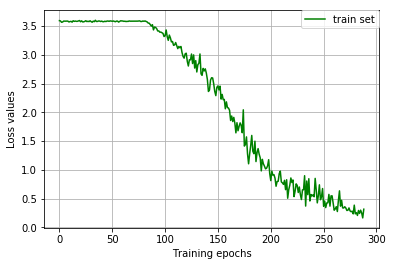

In [8]:
plot_loss()